## Study of the class-variance of features

This notebook is dedicated to studying the class-variance of features of the datasets used to test wether the mean is more robust than robust aggregators.


In [1]:
from torchvision import datasets, transforms
from byzfl import DataDistributor
from torch.utils.data import DataLoader, Subset
from byzfl.utils.misc import set_random_seed


### Extraits de byzfl (datasets disponibles, transformations)

In [2]:
#datasets available in byzfl. For now, we do not apply the normalizations because in "mean is more robust", there does not seem to be any.

# transforms_hflip = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
# transforms_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# transforms_cifar_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
# transforms_cifar_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# #Supported datasets
# dict_datasets = {
#     "mnist":        ("MNIST", transforms_mnist, transforms_mnist),
#     "fashionmnist": ("FashionMNIST", transforms_hflip, transforms_hflip),
#     "emnist":       ("EMNIST", transforms_mnist, transforms_mnist),
#     "cifar10":      ("CIFAR10", transforms_cifar_train, transforms_cifar_test),
#     "cifar100":     ("CIFAR100", transforms_cifar_train, transforms_cifar_test),
#     "imagenet":     ("ImageNet", transforms_hflip, transforms_hflip)
# }


### Plot des distributions et variances

La case ci-dessous permet de modifier les distributions et leurs paramètres, notamment:
- le dataset sous-jacent via dataset_name
- le nombre de classes simulées
- les distributions simulées via data_distributions
- les paramètres des distributions via dirichlet_parameter_list
- la batch size
- le nombre de clients

- 


In [ ]:
dataset_name = "MNIST"
num_classes=10
set_random_seed(100)
batch_size = 128 #anecdotique car on ne crée pas de dataloader

data_distributions=["dirichlet_niid","dirichlet_niid_modified", "iid", "extreme_niid", "extreme_niid_modified"]
# data_distributions=["extreme_niid","extreme_niid_modified"]


dirichlet_parameter_list=[0.001,0.01,0.03,0.05,0.1, 1.0, 10.0]

nb_honest = 10 #nombre de workers

dataset = getattr(datasets, dataset_name)(
            root = "../data", 
            train = True, 
            download = True,
            transform = None
    )

#Pour CIFAR, on convertit en tensor pour unifier le traitement entre datasets
if dataset_name in ["CIFAR10", "CIFAR100"]:
        dataset.transform = transforms.Compose([
        transforms.ToTensor()])


In [ ]:
import torch as torch

### On reprend ici le code de DataDistributor de byzfl, mais en modifiant le split pour ne pas obtenir de dataloader (plus simple pour plotter)
def create_data_splits(data_loader, data_distribution_name, distribution_parameter, nb_honest, batch_size):
    print("create data split for "+data_distribution_name + str(distribution_parameter))
    params= {
        "data_loader": data_loader,
        "data_distribution_name": data_distribution_name,
        "nb_honest": nb_honest,
        "batch_size": batch_size,
        "distribution_parameter": distribution_parameter
    }
    distributor = DataDistributor(params)

    ## Ensuite, on reprend la méthode "split data" de DataDistributor, sans crée de dataloader afin de faciliter le plotting:

    targets = data_loader.dataset.targets
    targets = torch.tensor(targets) 
    if isinstance(data_loader, DataLoader):
        idx = list(range(len(targets)))
    else:
        idx = data_loader.indices

    if data_distribution_name == "iid":
        split_idx = distributor.iid_idx(idx)
    elif data_distribution_name == "gamma_similarity_niid":
        split_idx = distributor.gamma_niid_idx(targets, idx)
    elif data_distribution_name == "dirichlet_niid":
        split_idx = distributor.dirichlet_niid_idx(targets, idx)
    elif data_distribution_name == "dirichlet_modified_niid":
        split_idx = distributor.dirichlet_niid_idx(targets, idx)
    elif data_distribution_name == "extreme_niid":
        split_idx = distributor.extreme_niid_idx(targets, idx)
    elif data_distribution_name == "dirichlet_niid_modified":
            split_idx= distributor.dirichlet_niid_modified_idx(targets, idx, min_size=3000) #modified to account for minimal per node-batch size.
    elif data_distribution_name == "extreme_niid_modified":
        split_idx = distributor.extreme_niid_modified_idx( targets, idx)
        
    else:
        raise ValueError(f"Invalid value for data_distribution_name: {data_distribution_name}")
        
    ##ENfin, on récupère les données:

    subsets=[]
    for i in range(len(split_idx)):
        subset = Subset(data_loader.dataset, split_idx[i])
        subsets.append(subset)
    return subsets

create data split for dirichlet_niid0.001


C:\Users\mathi\AppData\Local\Temp\ipykernel_28236\2780694245.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


create data split for dirichlet_niid0.01
create data split for dirichlet_niid0.03
create data split for dirichlet_niid0.05
create data split for dirichlet_niid0.1
create data split for dirichlet_niid1.0
create data split for dirichlet_niid10.0
create data split for dirichlet_niid_modified0.001


c:\Users\mathi\OneDrive\Academique\X\3A\EA_AI_Safety\code\mean_robustness\.venv\Lib\site-packages\byzfl\fed_framework\data_distributor.py:297: RuntimeWarning: invalid value encountered in divide
  proportions = proportions / proportions.sum()
c:\Users\mathi\OneDrive\Academique\X\3A\EA_AI_Safety\code\mean_robustness\.venv\Lib\site-packages\byzfl\fed_framework\data_distributor.py:298: RuntimeWarning: invalid value encountered in cast
  proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
c:\Users\mathi\OneDrive\Academique\X\3A\EA_AI_Safety\code\mean_robustness\.venv\Lib\site-packages\byzfl\fed_framework\data_distributor.py:295: RuntimeWarning: invalid value encountered in scalar multiply
  [p * (len(idx_j) < data_size / self.nb_honest) for p, idx_j in zip(proportions, partition)])


create data split for dirichlet_niid_modified0.01
create data split for dirichlet_niid_modified0.03
create data split for dirichlet_niid_modified0.05
create data split for dirichlet_niid_modified0.1
create data split for dirichlet_niid_modified1.0
create data split for dirichlet_niid_modified10.0
create data split for iid0.0
create data split for extreme_niid0.0
create data split for extreme_niid_modified0.0


In [ ]:
data_splits = {dist+" α="+str(dirichlet_param) if dirichlet_param else dist: create_data_splits(DataLoader(dataset, batch_size=batch_size, shuffle=True), dist, dirichlet_param, nb_honest, batch_size) for dist in data_distributions for dirichlet_param in (dirichlet_parameter_list if "dirichlet" in dist else [0.0])}

### On peut maintenant plot les distributions par classe par worker:

C:\Users\mathi\AppData\Local\Temp\ipykernel_28236\2747707416.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)  # ou 'nipy_spectral', 'turbo', 'viridis'...


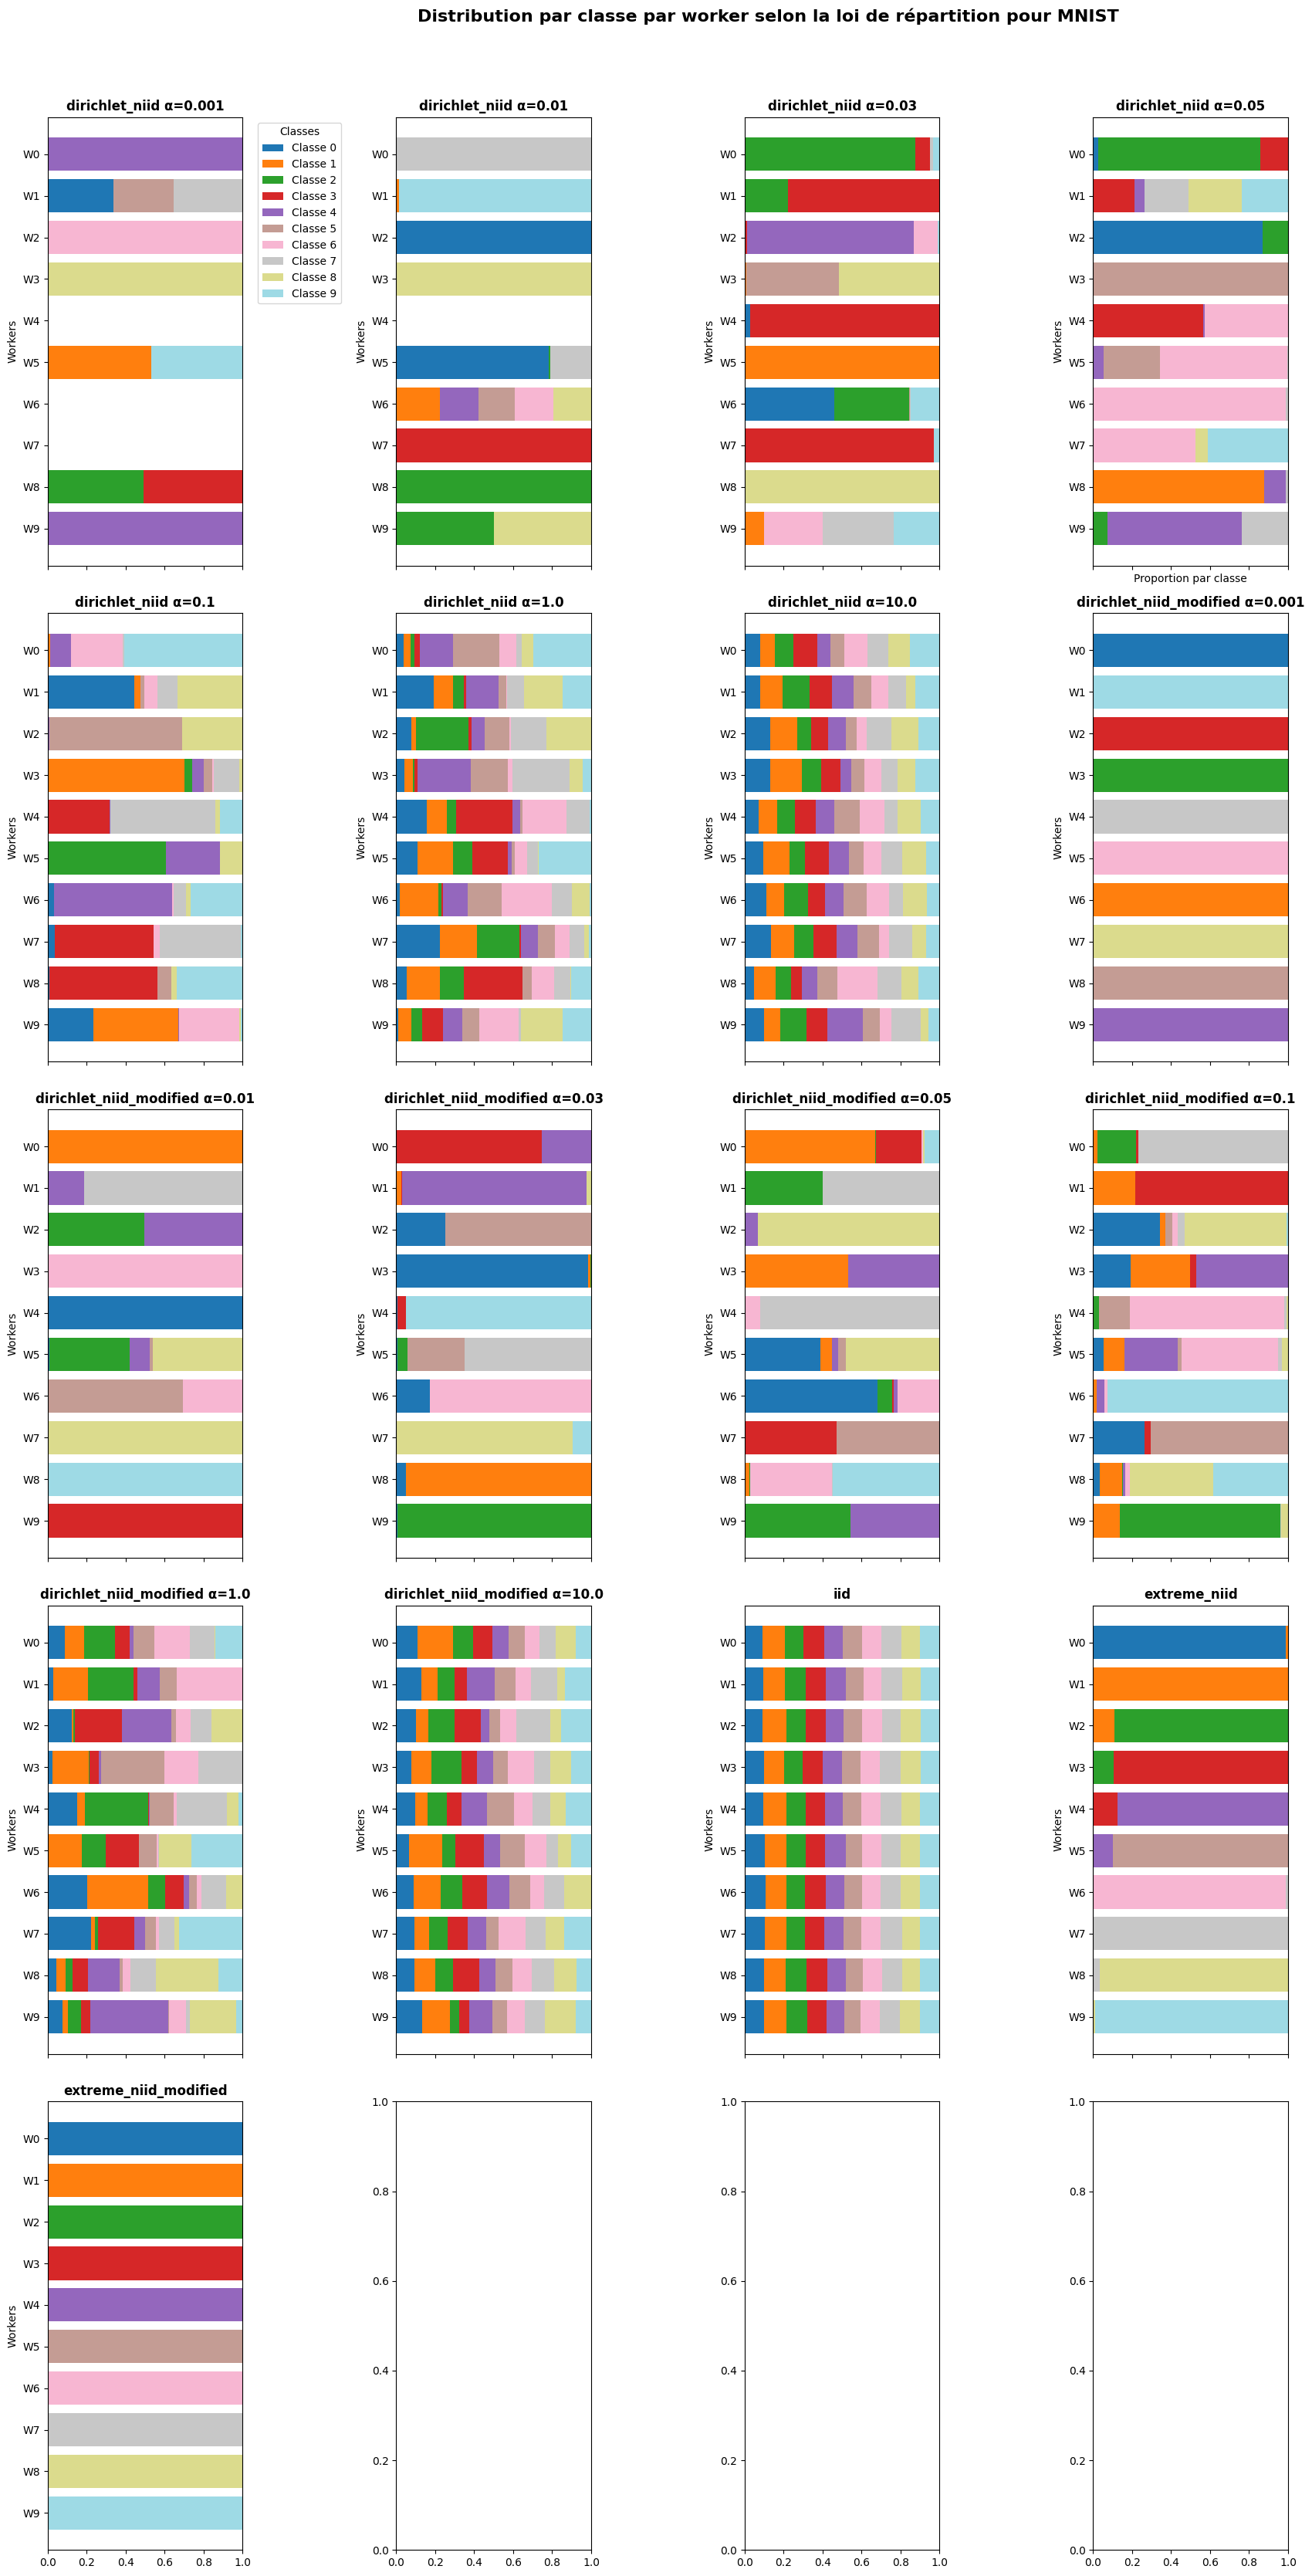

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_worker_distributions_compact(data_splits, num_classes=10):
    """
    data_splits: dict
        Clés = noms des distributions (ex: 'Dirichlet α=0.1')
        Valeurs = liste de Subset (un Subset par worker)
    """
    dist_names = list(data_splits.keys())
    n_dists = len(dist_names)
    if (num_classes<10):
        colors = plt.cm.tab10.colors
        
    else:
        cmap = plt.cm.get_cmap('tab20', num_classes)  # ou 'nipy_spectral', 'turbo', 'viridis'...
        colors = [cmap(i) for i in range(num_classes)]
      
    fig, axes = plt.subplots((n_dists //4)+1, 4, figsize=(20,2*len(dist_names)), sharex=True)
    if n_dists == 1:
        axes = [axes]  # pour itérer même s’il y a un seul plot

    for ax, dist_name in zip(axes.flat, dist_names):
        subsets = data_splits[dist_name]
        num_workers = len(subsets)

        # Calcul des proportions par worker
        proportions = []
        for subset in subsets:
            targets = np.array([subset.dataset.targets[idx] for idx in subset.indices])
            counts = Counter(targets)
            total = len(targets)
            prop = [counts.get(c, 0) / total if total > 0 else 0 for c in range(num_classes)]
            proportions.append(prop)
        proportions = np.array(proportions)

        # Plot horizontal empilé
        left = np.zeros(num_workers)
        for c in range(num_classes):
            ax.barh(range(num_workers), proportions[:, c], left=left,
                    color=colors[c], label=f'Classe {c}' if ax == axes[0][0] else None)
            left += proportions[:, c]

        ax.set_yticks(range(num_workers))
        ax.set_yticklabels([f'W{i}' for i in range(num_workers)])
        ax.set_title(dist_name, fontsize=12, weight='bold')
        ax.set_ylabel('Workers')
        ax.invert_yaxis()  # pour que W0 soit en haut

    axes[0][-1].set_xlabel('Proportion par classe')
    axes[0][0].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"Distribution par classe par worker selon la loi de répartition pour {dataset_name}", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.show()
    
plot_worker_distributions_compact(data_splits, num_classes=num_classes)



### Enfin, on calcule la variance des features par worker

C:\Users\mathi\AppData\Local\Temp\ipykernel_28236\3345018366.py:27: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  variances.append(torch.var(all_pixels).item())


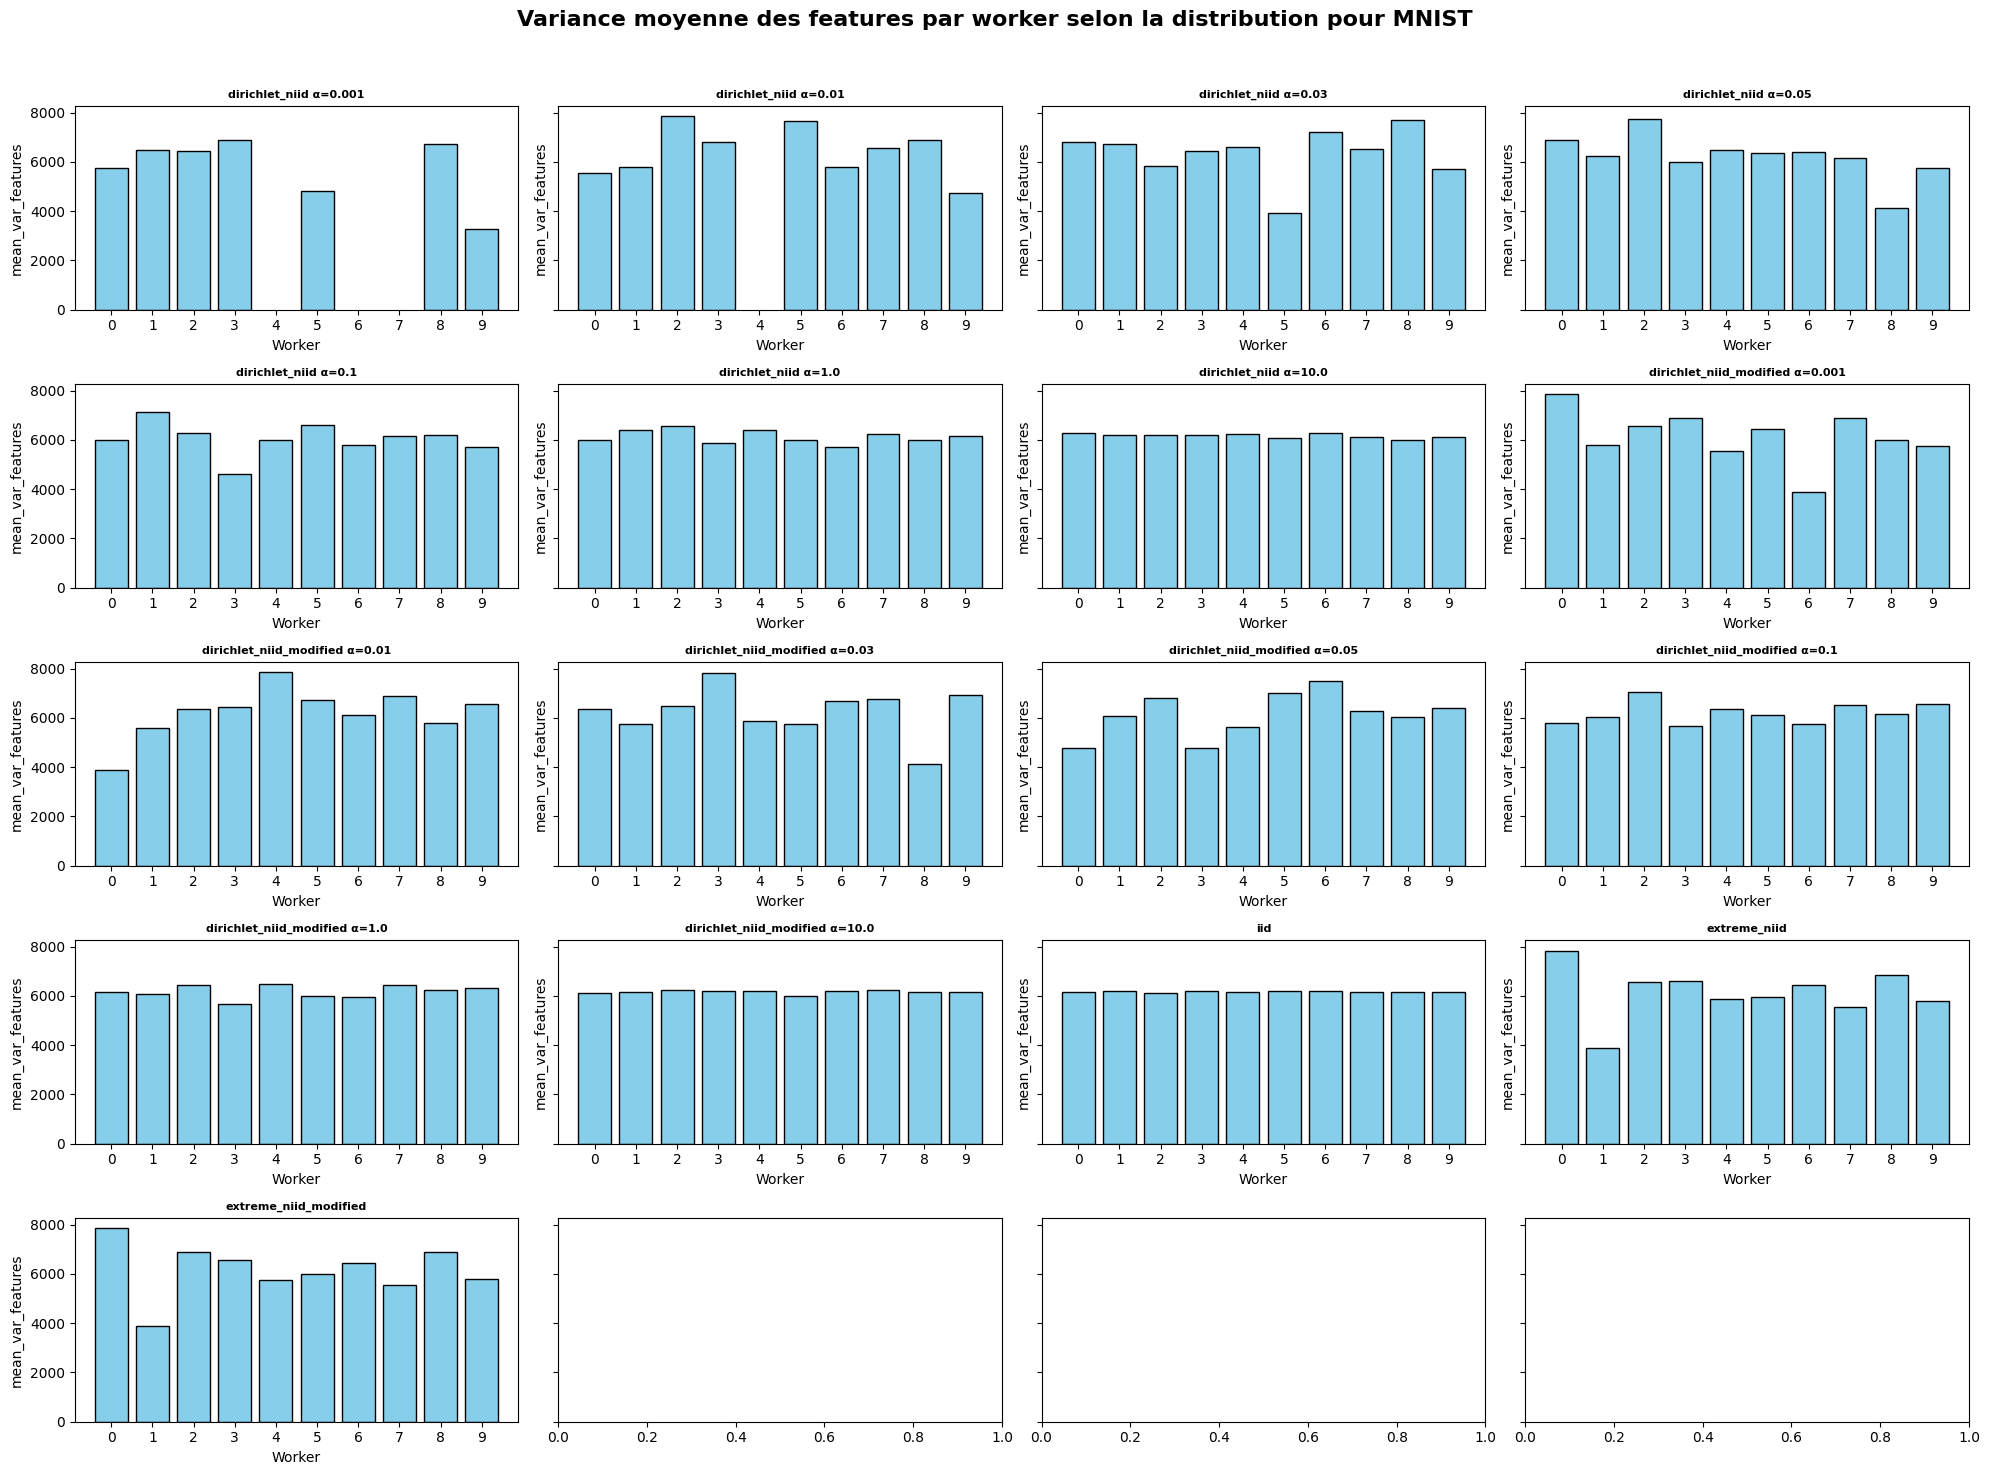

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from torchvision import transforms

from torchvision import transforms

to_tensor = transforms.ToTensor()

def compute_feature_variances_flatten(subsets):
    """
    Pour chaque worker, flatten toutes les images en vecteur et calculer
    la variance globale sur tous les pixels.
    """
    variances = []
    for subset in subsets:
        data = subset.dataset.data
        if isinstance(data, np.ndarray):
                imgs = torch.tensor(data[subset.indices])  # conversion numpy -> tensor
        else:
            imgs = data[subset.indices]

        all_pixels = imgs.reshape(-1).float()
        # variance globale sur tous les pixels
        variances.append(torch.var(all_pixels).item())
    return np.array(variances)



def plot_feature_variances_compact(data_splits):
    """
    data_splits: dict
        Clés = noms des distributions
        Valeurs = liste de Subset (un par worker)
    """
    dist_names = list(data_splits.keys())
    n_dists = len(dist_names)

    fig, axes = plt.subplots(n_dists//4 +1, 4, figsize=(20,15), sharey=True)
    if n_dists == 1:
        axes = [axes]

    for ax, dist_name in zip(axes.flat, dist_names):
        subsets = data_splits[dist_name]
        variances = compute_feature_variances_flatten(subsets)
        num_workers = len(variances)

        ax.bar(range(num_workers), variances, color="skyblue", edgecolor="black")
        ax.set_title(dist_name, fontsize=8, weight='bold')
        ax.set_xlabel("Worker")
        ax.set_ylabel("mean_var_features")

        ax.set_xticks(range(num_workers))
        # ax.set_xticklabels([f"W{i}" for i in range(num_workers)])

    plt.suptitle(f"Variance moyenne des features par worker selon la distribution pour {dataset_name}", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
plot_feature_variances_compact(data_splits)


### On étudie également les tailles des différentes sub-datasets

On observe bien que certains clients n'ont pas de données...

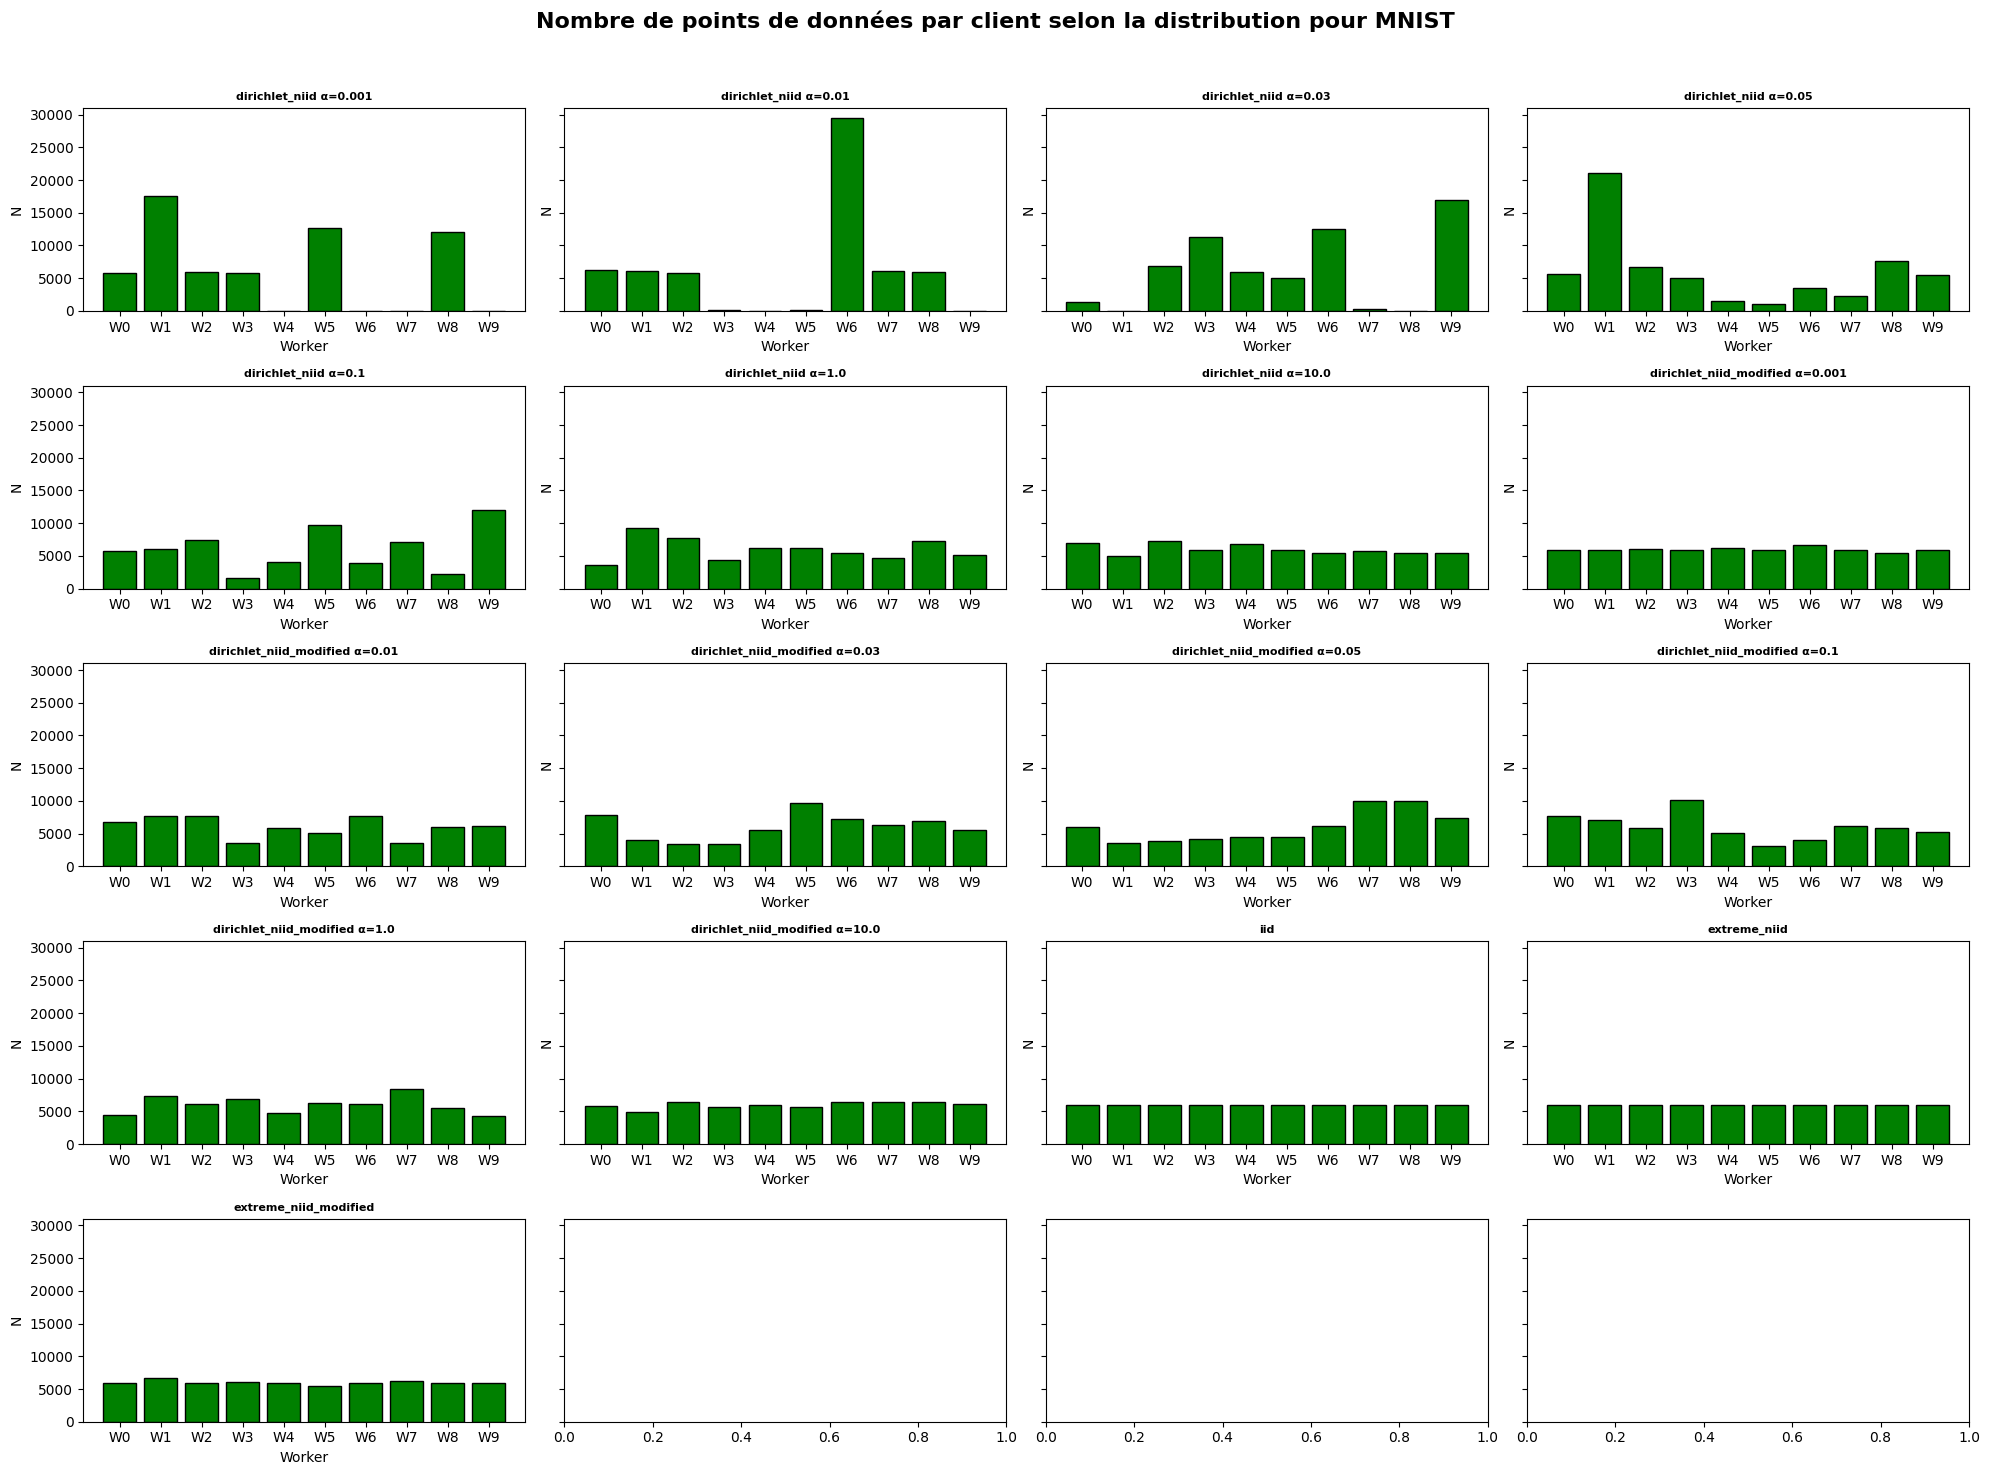

In [26]:
# ### plot sizes
# for dist_name, subsets in data_splits.items():
#     print(f"--------------Distribution: {dist_name}---------------")
#     for index, subset in enumerate(subsets):
#         data = subset.indices
#         print(f"Data shape for {index}: {len(data)}")
        
        
def plot_subset_lengths(data_splits):
    """
    data_splits: dict
        Clés = noms des distributions
        Valeurs = liste de Subset (un par worker)
    """
    dist_names = list(data_splits.keys())
    n_dists = len(dist_names)

    fig, axes = plt.subplots(n_dists//4 +1, 4, figsize=(20,15), sharey=True)
    if n_dists == 1:
        axes = [axes]

    for ax, dist_name in zip(axes.flat, dist_names):
        subsets = data_splits[dist_name]
        lengths=[len(subset.indices) for subset in subsets]
        num_workers = len(lengths)

        ax.bar(range(num_workers), lengths, color="green", edgecolor="black")
        ax.set_title(dist_name, fontsize=8, weight='bold')
        ax.set_xlabel("Worker")
        ax.set_ylabel("N")

        ax.set_xticks(range(num_workers))
        ax.set_xticklabels([f"W{i}" for i in range(num_workers)])

    plt.suptitle(f"Nombre de points de données par client selon la distribution pour {dataset_name}", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
plot_subset_lengths(data_splits)
